<a href="https://colab.research.google.com/github/lnsayer/personal_repo/blob/main/drug%20discovery%20with%20BACE%20dataset/graph_classification_bace_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Installed rdkit, torch_geometric, deepchem, networkx, torchmetrics into google drive with pip. With this resource https://netraneupane.medium.com/how-to-install-libraries-permanently-in-google-colab-fb15a585d8a5
# This method ends up taking around 200s, whilst installing the libraries themselves takes around 100s which is more efficient.

In [7]:
from timeit import default_timer as timer

In [8]:
start_time = timer()
!pip install rdkit
!pip install torch_geometric
!pip install deepchem
!pip install networkx
!pip install torchmetrics
end_time = timer()
print(f"Time for cell to run: {end_time-start_time:.4f}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64

In [9]:
# Import necessary modules
import requests
from pathlib import Path
import os.path as osp

from rdkit import Chem
from rdkit.Chem import Draw

import torch
import torch_geometric
from torch_geometric.data import InMemoryDataset, Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv, GATConv, MLP, GINConv, global_max_pool, SAGPooling, TopKPooling, GINEConv
from torch.nn import Linear, ReLU, Dropout, Softmax
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import BinaryAUROC, BinaryPrecision, BinaryRecall


import deepchem as dc
from deepchem.feat.graph_data import GraphData

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pandas import DataFrame

import networkx as nx

import random

from tqdm.auto import tqdm
from timeit import default_timer as timer

from IPython.display import Javascript

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [10]:
import os
google_drive_path = Path("drive/MyDrive")
# Prints all subdirectories (takes ages)
# for dirpath, dirnames, filenames in os.walk(google_drive_path):
#    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [11]:
bace_project_path = google_drive_path / "bace_graph_project"
bace_raw_path = bace_project_path / "data/raw"

In [12]:
# Check if Bace csv file has been downloaded, if not, download it
if bace_raw_path.is_dir():
  print(f"{bace_raw_path} is already a directory")
else:
  print(f"{bace_raw_path} is not a directory, creating one")
  bace_raw_path.mkdir(parents=True, exist_ok=True)

  with open(bace_raw_path / "bace.csv", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/lnsayer/personal_repo/main/drug%20discovery%20with%20BACE%20dataset/data/bace.csv")
    print("Downloading data")
    f.write(request.content)

drive/MyDrive/bace_graph_project/data/raw is already a directory


In [13]:
bace_raw_path

PosixPath('drive/MyDrive/bace_graph_project/data/raw')

In [14]:
# Turn CSV file into a dataframe and resave it without unnecessary columns
bace_df = pd.read_csv(bace_raw_path/ "bace.csv")
bace_df = bace_df[["mol", "CID", "Class", "Model", "pIC50"]]
bace_df.to_csv(bace_raw_path/"bace.csv")

bace_df

,mol,CID,Class,Model,pIC50
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970
...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298


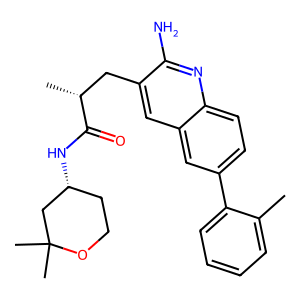

In [15]:
# Visualise one of the molecules from its SMILE input
inhibitor = bace_df["mol"][0]

m = Chem.MolFromSmiles(inhibitor)

img = Draw.MolToImage(m)

display(img)

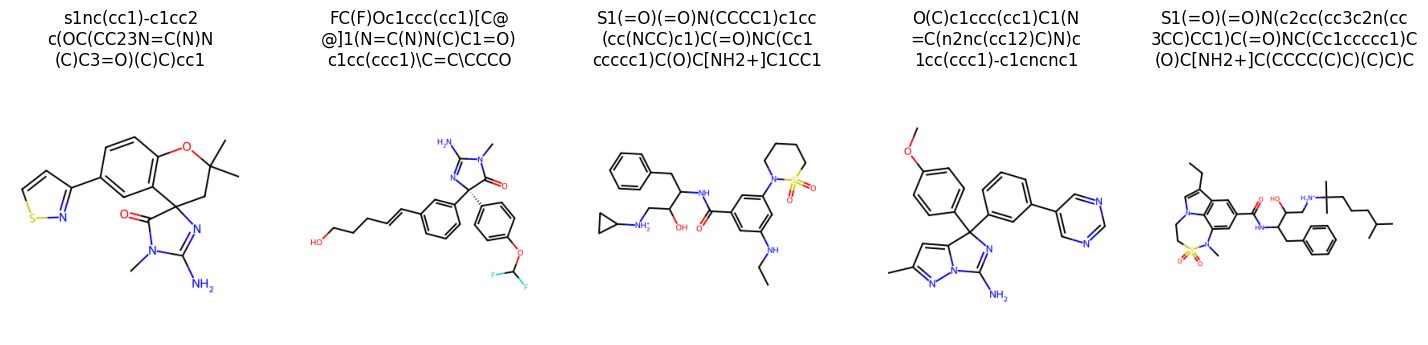

In [16]:
# Display five random molecules with their SMILES molecules

# Create axes and sample SMILES molecules
fig, ax = plt.subplots(ncols=5, nrows=1, figsize = (18,6))
mols = bace_df.sample(n=5, random_state=42)["mol"]

for i in range(len(mols)):

  # Convert each molecule to an image
  mol = mols.iloc[i]
  m = Chem.MolFromSmiles(mol)
  img = Draw.MolToImage(m)

  # Plot each molecule
  ax[i].imshow(img)
  ax[i].axis(False);

  # Divide the SMILE input into three parts
  first_part = mol[:int(len(mol)/3)]
  second_part = mol[int(len(mol)//3):int(2*len(mol)//3)]
  third_part = mol[int(2*len(mol)//3):]

  assert len(mol) == len(first_part)+len(second_part)+len(third_part)

  first_title = first_part + "\n"
  second_title = second_part + "\n"
  third_title = third_part + "\n"

  # Title each plot with its respective SMILE input
  ax[i].set_title(first_title+second_title+third_title)

In [17]:
# Test converting a molecule into a graph using MolGraphConvFeaturizer and to_pyg_graph

# Select first molecule
mol = bace_df["mol"][1]

# Instantiate MolGraphConvFeaturizer class
featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

# Convert SMILES molecule into a DeepChem graph
out = featurizer.featurize(datapoints=mol)

# Convert into torch geometric graph
pyg_out = GraphData.to_pyg_graph(out[0])
pyg_out.y = torch.tensor([bace_df["Class"][0]])

print(pyg_out)

Data(x=[47, 30], edge_index=[2, 100], edge_attr=[100, 11], y=[1])


In [18]:
# Custom torch geometric Dataset class to store the samples and their corresponding labels

class MoleculeDataset(Dataset):
  def __init__(self, root, csv_file, transform=None, pre_transform=None, pre_filter=None):
    """
    root = Where the dataset should be stored. This folder is split
    into raw_dir (downloaded dataset) and processed_dir(processed data).
    """
    self.csv_file = csv_file
    super().__init__(root, transform, pre_transform, pre_filter)

  @property
  def raw_file_names(self):
    """
    If this file exists in raw_dir, the download is not triggered/
    (the download function is not implemented here)
    """
    return self.csv_file

  @property
  def processed_file_names(self):
    """
    If these files are found in raw_dir, processing is skipped
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()

    return [f'data_{i}.pt' for i in list(self.data.index)]

  def download(self):
    """
    No need to download the csv file as it is already downloaded
    """
    pass

  def process(self):
    """
    I used Deepchem's MolGraphConvFeaturizer to create a graph and then convert that to a torch graph with to_pyg_graph.
    """
    self.data = pd.read_csv(self.raw_paths[0]).reset_index()
    featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True)

    for idx, row in self.data.iterrows():
      # Featurize molecule and convert to torch graph
      smiles = row['mol']
      label = row['Class']
      pic50 = row['pIC50']

      out = featurizer.featurize(smiles)
      pyg_out = GraphData.to_pyg_graph(out[0])
      pyg_out.Class = torch.tensor([label])
      pyg_out.smiles = smiles
      pyg_out.pic50 = pic50

      # data = Data(x=pyg_out.x, edge_index=pyg_out.edge_index, edge_attr=pyg_out.edge_attr,
      #            y=torch.tensor([label]), dtype = torch.float)

      torch.save(pyg_out, osp.join(self.processed_dir, f'data_{idx}.pt'))

  def len(self):
    """
    Returns number of samples in the dataset
    """
    return len(self.processed_file_names)

  def get(self, idx):
    """
    Loads a single graph
    """
    data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
    return data

In [19]:
# Instantiate the dataset from the BACE CSV file

original_dataset = MoleculeDataset(root = "drive/MyDrive/bace_graph_project/data/", csv_file = "bace.csv").shuffle()
dataset = original_dataset

train_indices = int(0.8*len(dataset))

train_dataset = dataset[:train_indices]
test_dataset = dataset[train_indices:]


print(f"Total dataset samples: {len(dataset)}\nTrain dataset samples: {len(train_dataset)}\nTest dataset samples: {len(test_dataset)}")

Total dataset samples: 1513
Train dataset samples: 1210
Test dataset samples: 303


In [20]:
# Calculate average nodes and edges in the graphs
avg_nodes = 0
avg_edges = 0
"""
for i in tqdm(range(len(original_dataset))):
  avg_nodes+=original_dataset[i].x.shape[0]
  avg_edges+=original_dataset[i].edge_index.shape[1]
avg_nodes = avg_nodes/len(original_dataset)
avg_edges = avg_edges/len(original_dataset)
print(f"avg nodes: {avg_nodes:.4f}, avg_edges: {avg_edges:.4f}")
"""
# Computation takes along time, results:
print("avg nodes: 34.0892, avg_edges: 73.7184")

avg nodes: 34.0892, avg_edges: 73.7184


In [21]:
# Create a dataloader from the dataset
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"Number of batches: {len(train_dataloader)}")
print(f"Number of samples: {len(train_dataset)}")

Number of batches: 38
Number of samples: 1210


In [22]:
# Load a single graph

print(f"Number of nodes in graph is: {train_dataset[0].x.shape[0]}")
print(f"Number of features for each node is {train_dataset[0].num_features}")
print(f"Number of edges is {train_dataset[0].edge_index.shape[1]}")
print(f"Data object is {train_dataset[0]}\n")

Number of nodes in graph is: 25
Number of features for each node is 30
Number of edges is 54
Data object is Data(x=[25, 30], edge_index=[2, 54], edge_attr=[54, 11], Class=[1], smiles='Clc1ccc(nc1)C(=O)Nc1cc(ccc1)C1(N=C(N)CNC1=O)C', pic50=6.4584208)



In [23]:
# Node features for one the graphs. This class is a featurizer of general graph convolution networks for molecules.
# The default node(atom) and edge(bond) representations are based on WeaveNet paper.

# train_dataset[0].x

In [24]:
# See the format for a batch
print(next(iter(train_dataloader)))

DataBatch(x=[1048, 30], edge_index=[2, 2266], edge_attr=[2266, 11], Class=[32], smiles=[32], pic50=[32], batch=[1048], ptr=[33])


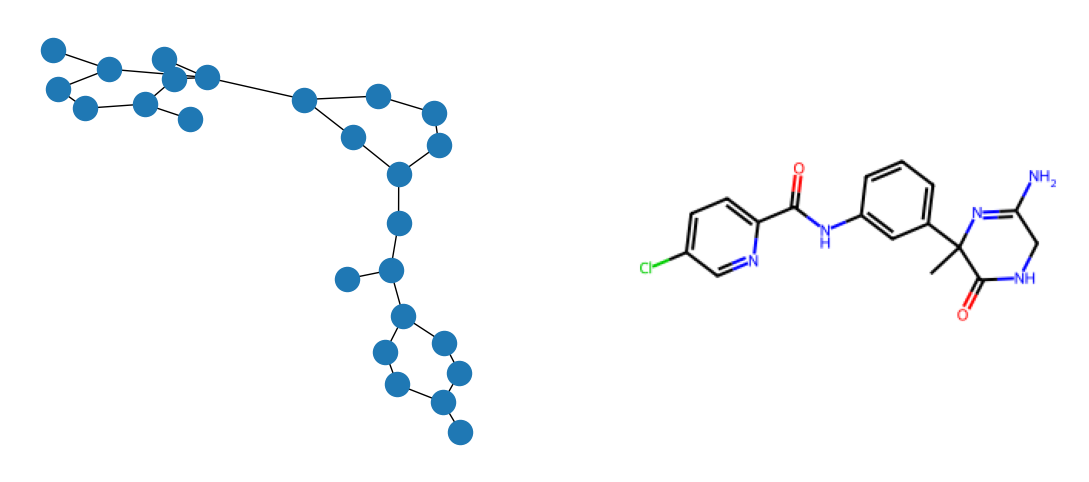

In [25]:
np.random.seed(44)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

g = torch_geometric.utils.to_networkx(train_dataset[0], to_undirected=True)
nx.draw(g, ax = ax[0])

mol = dataset[0].smiles
m = Chem.MolFromSmiles(mol)
img = Draw.MolToImage(m)

ax[1].imshow(img)
ax[1].axis(False);

In [26]:
# Print 5 batches
i = 0
for batch in train_dataloader:
  while i <5:
    print(batch)
    i+=1

DataBatch(x=[1166, 30], edge_index=[2, 2494], edge_attr=[2494, 11], Class=[32], smiles=[32], pic50=[32], batch=[1166], ptr=[33])
DataBatch(x=[1166, 30], edge_index=[2, 2494], edge_attr=[2494, 11], Class=[32], smiles=[32], pic50=[32], batch=[1166], ptr=[33])
DataBatch(x=[1166, 30], edge_index=[2, 2494], edge_attr=[2494, 11], Class=[32], smiles=[32], pic50=[32], batch=[1166], ptr=[33])
DataBatch(x=[1166, 30], edge_index=[2, 2494], edge_attr=[2494, 11], Class=[32], smiles=[32], pic50=[32], batch=[1166], ptr=[33])
DataBatch(x=[1166, 30], edge_index=[2, 2494], edge_attr=[2494, 11], Class=[32], smiles=[32], pic50=[32], batch=[1166], ptr=[33])


KeyboardInterrupt: 

In [29]:
# Create tensor of the average of the node features for all 1210 training samples
a = torch.tensor(())
for idx, data in enumerate(train_dataloader):
  x = global_mean_pool(data.x, data.batch)
  a = torch.cat((a, x), 0)


KeyboardInterrupt: 

In [ ]:
print(a.shape)
df = pd.DataFrame(a.numpy())
# display(df)
corr = df.corr()
# corr.style.background_gradient(cmap='coolwarm')

In [ ]:
class GCNClassifier(torch.nn.Module):
  """
  Standard GCN graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, pool_method:torch_geometric.nn.pool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GCNConv(in_channels, hidden_channels)

    self.conv2 = GCNConv(hidden_channels, hidden_channels)

    self.conv3 = GCNConv(hidden_channels, hidden_channels)

    # Linear layer used in classification
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    x = self.conv1(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv2(x, edge_index)
    x = F.leaky_relu(x)
    x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GCNClassifier(7, 64, 2, global_mean_pool)

In [ ]:
class GraphConvClassifier(GCNClassifier):
  """
  Same architecture as GCN Classifier however use GraphConv layers
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int,  pool_method:torch_geometric.nn.pool):
    super().__init__(in_channels, hidden_channels, out_channels, pool_method)
    self.conv1 = GraphConv(in_channels, hidden_channels)

    self.conv2 = GraphConv(hidden_channels, hidden_channels)

    self.conv3 = GraphConv(hidden_channels, hidden_channels)
GraphConvClassifier(7, 64, 2, global_mean_pool)

In [ ]:
class GATClassifier(torch.nn.Module):
  """
  GAT Convolutional graph classifier
  """
  def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, heads:int, pool_method:torch_geometric.nn.pool,
               use_edge_attr:bool):
    super().__init__()
    # Convolutional Layers
    self.conv1 = GATConv(in_channels,
                         hidden_channels,
                         heads,
                         concat = True)
    self.conv2 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         heads,
                         concat=True)
    self.conv3 = GATConv(hidden_channels*heads,
                         hidden_channels,
                         1,
                         concat=False)
    self.lin = Linear(hidden_channels, out_channels)

  def forward(self, data):
    # Obtain node embeddings
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

    # can use edge attributes
    if use_edge_attr:
      x = self.conv1(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index, edge_attr)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index, edge_attr)

    # not using edge attributes
    else:
      x = self.conv1(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv2(x, edge_index)
      x = F.leaky_relu(x)
      x = self.conv3(x, edge_index)

    # Aggregate node embeddings
    x = pool_method(x, batch)

    # Regularisation
    x = F.dropout(x)

    # Classification
    x = self.lin(x)

    x = F.softmax(x, dim=1)

    return x

GATClassifier(30, 64, 2, 8, global_max_pool, True)

In [ ]:
type(GINConv(nn))

In [ ]:
class GINConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINConv

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    for conv in self.convs:
      x = conv(x, edge_index).relu()
    x = pool_method(x, batch)
    return self.mlp(x)

GINConvClassifier(30, 64, 2, 3, global_mean_pool)

In [ ]:
class GINEConvClassifier(torch.nn.Module):
  """
  Applies the graph isomorphism operator
  """
  def __init__(self, in_channels, hidden_channels, out_channels, num_layers, pool_method: torch_geometric.nn.pool,
               use_edge_attr:bool, edge_dim:int):
    super().__init__()

    self.convs = torch.nn.ModuleList()
    self.conv = GINEConv
    self.use_edge_attr = use_edge_attr
    self.edge_dim = edge_dim

    for _ in range(num_layers):
      mlp = MLP([in_channels, hidden_channels, hidden_channels])
      self.convs.append(self.conv(nn=mlp, train_eps=False, edge_dim=self.edge_dim))
      in_channels = hidden_channels

    self.mlp = MLP([hidden_channels, hidden_channels, out_channels], norm = None, dropout = 0.5)

  def forward(self, data):
    x, edge_index, batch, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr
    for conv in self.convs:
      if self.use_edge_attr:
        x = conv(x, edge_index, edge_attr).relu()
      else:
        x = conv(x, edge_index).relu()

    x = pool_method(x, batch)
    return self.mlp(x)

GINEConvClassifier(30, 64, 2, 3, global_mean_pool, True, dataset[0].edge_attr.shape[1])

In [ ]:
dataset[2].edge_attr.shape[1]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
auroc_metric = BinaryAUROC(thresholds=None)

def train_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  overall_start_time = timer()
  # Send model to device
  test_start_time = timer()
  model.to(device)
  model.train()

  train_loss, train_acc, train_auc = 0, 0, 0


  auc_time = 0
  out_time = 0
  loss_time = 0
  optimizer_time = 0

  loop_start_time = timer()
  # Loop over the batches
  for batch in dataloader:
    batch = batch.to(device)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Forward pass
    out_start_time = timer()
    out = model(batch)
    out_end_time = timer()
    out_time+=out_end_time-out_start_time


    # Calculate the loss
    loss = loss_fn(out, batch.Class)
    train_loss += loss.item()

    # Calculate the label predictions
    label_preds = torch.argmax(out, dim=1)
    # Calculate accuracy
    train_acc += (label_preds == batch.Class).sum()

    # Calculate the AUC
    auc_start_time = timer()
    train_auc += auroc_metric(out[:,1], batch.Class).item()
    auc_end_time = timer()
    auc_time += auc_end_time-auc_start_time

    # Loss backward
    loss_start_time = timer()
    loss.backward()
    loss_end_time = timer()
    loss_time = loss_end_time-loss_start_time

    # Optimizer step
    optimizer_start_time = timer()
    optimizer.step()
    optimizer_end_time = timer()
    optimizer_time = optimizer_end_time-optimizer_start_time

  test_end_time = timer()
  print(f"test time is {test_end_time-test_start_time}")

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/len(dataloader.dataset)
  train_acc = train_acc/len(dataloader.dataset)
  train_auc = train_auc/len(dataloader)
  print(f"auc_time is {auc_time}")
  print(f"out_time is {out_time}")
  print(f"loss_time is {loss_time}")
  print(f"optimizer time is {optimizer_time}")
  loop_end_time = timer()
  print(f"loop time is{loop_start_time-loop_end_time}")


  overall_end_time = timer()
  print(f"Overall time is {overall_end_time -overall_start_time}")

  return train_loss, train_acc, train_auc

In [ ]:
def test_step(model:torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  # Put model in eval mode
  model.eval()

  test_loss, test_acc, test_auc = 0, 0, 0

  # Turn on torch inference manager
  with torch.inference_mode():
    # Loop through data batches
    for batch in dataloader:
      batch = batch.to(device)

      # Forward pass
      out = model(batch)

      # Calculate the loss
      loss = loss_fn(out, batch.Class)
      test_loss += loss.item()

      # Calculate the label predictions
      label_preds = torch.argmax(out, dim=1)
      # Calculate accuracy
      test_acc += (label_preds == batch.Class).sum()/len(label_preds)

      # Calculate the AUC
      test_auc += auroc_metric(out[:,1], batch.Class).item()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    test_auc = test_auc/len(dataloader)

    return test_loss, test_acc, test_auc

In [ ]:
# Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = torch.nn.CrossEntropyLoss(),
          epochs: int =5,
          model_save_path: str = None):

  # 2. Create empty results dictionary
  results = {"epoch": [],
             "train_loss": [],
             "train_acc": [],
             "train_auc": [],
             "test_loss": [],
             "test_acc": [],
             "test_auc": [],
             "saved_model_epoch": 0}
  # 3. Loop through training and testing steps for a number of epochs
  for i in tqdm(range(epochs)):
    start_time = timer()
    train_step_start_time = timer()
    train_loss, train_acc, train_auc = train_step(model,
                                       train_dataloader,
                                       loss_fn,
                                       optimizer)
    train_step_end_time = timer()
    print(f"train step time is{train_step_end_time-train_step_start_time}")
    test_step_start_time = timer()
    test_loss, test_acc, test_auc = test_step(model,
                                    test_dataloader,
                                    loss_fn,
                                    optimizer)
    test_step_end_time = timer()
    print(f"test step time is{test_step_end_time-test_step_start_time}")

    # 4. Print out what's happening
    print(f"Epoch: {i}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, Train AUC: {train_auc:.4f}, Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}, Test auc: {test_auc:.4f}")
    # 5. Update results dictionary
    append_start_time = timer()
    results["epoch"].append(i)
    results["train_loss"].append(round(train_loss, 4))
    results["train_acc"].append(round(train_acc.item(), 4))
    results["train_auc"].append(round(train_auc, 4))
    results["test_loss"].append(round(test_loss, 4))
    results["test_acc"].append(round(test_acc.item(), 4))
    results["test_auc"].append(round(test_auc, 4))
    append_end_time = timer()
    print(f"append time is{append_end_time-append_start_time:.4f}")

    # 6. If model_save_path provided, save the model to its path
    if model_save_path:
      save_start_time = timer()
      if i > 5 and results["test_loss"][-1] < np.mean(results["test_loss"][-5:-1]) and results["test_auc"][-1] > np.mean(results["test_auc"][-5:-1]):
        print(f"Saving model to: {model_save_path}")
        results["saved_model_epoch"] = i
        torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
                    f=model_save_path)
      save_end_time = timer()
      print(f"Saving time took {save_end_time-save_start_time:.4f} seconds")
      end_time  = timer()
      print(f"Epoch took {end_time-start_time:.2f} seconds")


  # 7. Return the filled results at the end of the epochs

  return results

In [ ]:
# Create model directory in drive to save models into
print(f"bace_project path: {bace_project_path}")
bace_models_path = bace_project_path / "models"
print(f"bace_models_path: {bace_models_path}\n")

if bace_models_path.is_dir():
  print(f"{bace_models_path} is already a directory")
else:
  print(f"{bace_models_path} is not a directory, creating one")
  bace_models_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# GCN Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
# with global mean pooling, best is around 100 epochs
nb_epochs = 200
pool_method = global_mean_pool

# Instantiating GCN Classifier
model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
sgd_optimizer = torch.optim.SGD(model.parameters())
criterion = torch.nn.CrossEntropyLoss()



bace_gcn_models_path = bace_models_path / "gcn_models"


if bace_gcn_models_path.is_dir():
  print(f"{bace_gcn_models_path} is already a directory")
else:
  print(f"{bace_gcn_models_path} is not a directory, creating one")
  bace_gcn_models_path.mkdir(parents=True, exist_ok=True)

for i in range(5):
  model_save_name = f"{i}_{num_hidden_channels}_{nb_epochs}_{pool_method.__name__}.pth"
  model_save_path  = bace_gcn_models_path / model_save_name
  results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs,
      model_save_path = model_save_path)


"""
results = train(model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""


In [ ]:
loaded_model = GCNClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Load a random model
model_save_path = bace_gcn_models_path/"0_128_5_global_mean_pool.pth"

print(model_save_path)
loaded_model.load_state_dict(torch.load(f=model_save_path))

loaded_model.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model(next(iter(test_dataloader)))
loaded_model_preds

In [ ]:
auroc_metric = BinaryAUROC(thresholds=None)

# Function which gives the AUC of a model and its metrics, as given by Scikit-Learn's classification report

def new_metric_func(model, train_dataloader, test_dataloader):
  with torch.inference_mode():
    model.eval()

    # Create empty tensors to fill with probabilities, predictions and labels
    total_train_probs = torch.empty(len(train_dataset))
    total_train_preds = torch.empty(len(train_dataset))
    total_train_labels = torch.empty(len(train_dataset))

    total_test_probs = torch.empty(len(test_dataset))
    total_test_preds = torch.empty(len(test_dataset))
    total_test_labels = torch.empty(len(test_dataset))

    # Loop over batches and add to the total tensors
    for idx, batch in enumerate(train_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      train_probs = out[:,1]
      train_preds = torch.argmax(out, dim=1)

      total_train_probs[idx*batch_size:idx*batch_size+current_batch_size] = train_probs
      total_train_preds[idx*batch_size:idx*batch_size+current_batch_size] = train_preds
      total_train_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    for idx, batch in enumerate(test_dataloader):
      batch = batch.to(device)
      batch_size = 32
      current_batch_size = len(batch)
      # print(f"{idx*batch_size}:{idx*batch_size+current_batch_size}")
      out = model.forward(batch)
      test_probs = out[:,1]
      test_preds = torch.argmax(out, dim=1)

      total_test_probs[idx*batch_size:idx*batch_size+current_batch_size] = test_probs
      total_test_preds[idx*batch_size:idx*batch_size+current_batch_size] = test_preds
      total_test_labels[idx*batch_size:idx*batch_size+current_batch_size] = batch.Class

    # Calculate AUC and dataframes of metrics (using Scikit-Learn's metrics)
    train_auroc = auroc_metric(total_train_probs, total_train_labels).item()
    train_classification_report = classification_report(total_train_labels, total_train_preds, output_dict=True)
    train_report_df = pd.DataFrame(data=train_classification_report).transpose()

    test_auroc = auroc_metric(total_test_probs, total_test_labels).item()
    test_classification_report = classification_report(total_test_labels, total_test_preds, output_dict=True)
    test_report_df = pd.DataFrame(data=test_classification_report).transpose()


  return train_auroc, test_auroc, train_report_df, test_report_df


In [ ]:
torch.manual_seed(42)
loaded_model = loaded_model.to(device)
train_auroc, test_auroc, train_classification_report, test_classification_report = new_metric_func(loaded_model, train_dataloader, test_dataloader)
print(train_auroc, test_auroc)
display(train_classification_report, test_classification_report)

In [ ]:
print(train_auroc)

In [42]:
start_time = timer()
train_auroc, test_auroc, train_report_df, test_report_df = new_metric_func(model, train_dataloader, test_dataloader)
end_time = timer()
print(round(end_time-start_time, 4))

5.5292


In [43]:
def loss_and_acc_plots(results):

  fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (14,6))

  ax[0].plot(results["epoch"], results["train_loss"], label="Train");
  ax[0].plot(results["epoch"], results["test_loss"],  label="Test");

  ax[1].plot(results["epoch"], results["train_acc"], label="Train");
  ax[1].plot(results["epoch"], results["test_acc"],  label="Test");

  ax[0].set_xlabel("Epochs", size=14)
  ax[0].set_ylabel("Loss", size=14)

  ax[1].set_xlabel("Epochs", size=14)
  ax[1].set_ylabel("Accuracy", size=14)

  ax[0].legend();
  ax[1].legend();

In [ ]:
# loss_and_acc_plots(results)

In [ ]:
# GAT Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
heads=4
# with no edge attributes, global mean pooling best is 70 epochs
nb_epochs = 70
use_edge_attr = True
pool_method = global_mean_pool

# Instantiating GAT Classifier
gat_model = GATClassifier(num_features, num_hidden_channels, num_out_channels, heads, pool_method, use_edge_attr)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gat_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


gat_results = train(gat_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)


In [ ]:
print(type(adam_optimizer))


In [ ]:
loss_and_acc_plots(gat_results)

In [ ]:
# GraphConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
# global mean pooling, best is 50 epochs
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GAT Classifier
graphconv_model = GraphConvClassifier(num_features, num_hidden_channels, num_out_channels, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(graphconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(graphconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

"""
graphconv_results = train(graphconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)
"""

In [ ]:
# loss_and_acc_plots(graphconv_results)

In [ ]:
# GINConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
nb_epochs = 50
pool_method = global_mean_pool

# Instantiating GINConv Classifier
ginconv_model = GINConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(ginconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(ginconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


ginconv_results = train(ginconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)



In [ ]:
# loss_and_acc_plots(ginconv_results)

In [ ]:
# GINEConv Classifier Training Run

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

torch.manual_seed(42)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Number of features of the graphs
num_features = next(iter(train_dataloader)).x.shape[1]
num_hidden_channels = 64
num_out_channels = 2
num_layers = 3
# best number of epochs with edge attributes is about 15
nb_epochs = 15
pool_method = global_mean_pool
use_edge_attr = True
edge_dim = dataset[0].edge_attr.shape[1]

# Instantiating GINEConv Classifier
gineconv_model = GINEConvClassifier(num_features, num_hidden_channels, num_out_channels, num_layers, pool_method, use_edge_attr, edge_dim)

# Instantiate optimizer and loss function
adam_optimizer = torch.optim.Adam(gineconv_model.parameters(), lr=0.001, weight_decay=1e-4)
sgd_optimizer = torch.optim.SGD(gineconv_model.parameters())
criterion = torch.nn.CrossEntropyLoss()


gineconv_results = train(gineconv_model,
      train_dataloader,
      test_dataloader,
      adam_optimizer,
      loss_fn = criterion,
      epochs = nb_epochs)


In [ ]:
loss_and_acc_plots(gineconv_results)

In [ ]:

gat_train_auroc, gat_test_auroc, gat_train_report_df, gat_test_report_df = metric_func(gat_model, train_dataset, test_dataset)
"""
graphconv_train_auroc, graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df = metric_func(graphconv_model, train_dataset, test_dataset)

ginconv_train_auroc, ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df = metric_func(ginconv_model, train_dataset, test_dataset)
"""
gineconv_train_auroc, gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df = metric_func(gineconv_model, train_dataset, test_dataset)



In [ ]:
"""
print("GCN results:")
display("train AUC:", train_auroc, "test AUC:", test_auroc, train_report_df, test_report_df)
"""
print("GAT results:")
display("train AUC:", gat_train_auroc, "test AUC:", gat_test_auroc, gat_train_report_df, gat_test_report_df)
"""
print("GraphConv results:")
display("train AUC:", graphconv_train_auroc, "test AUC:", graphconv_test_auroc, graphconv_train_report_df, graphconv_test_report_df)

print("GinConv results:")
display("train AUC:", ginconv_train_auroc, "test AUC:", ginconv_test_auroc, ginconv_train_report_df, ginconv_test_report_df)
"""
print("GineConv results:")
display("train AUC:", gineconv_train_auroc, "test AUC:", gineconv_test_auroc, gineconv_train_report_df, gineconv_test_report_df)